In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.decomposition import PCA

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# fix random seed for reproducibility
tf.random.set_seed(8)

Num GPUs Available:  1


In [12]:
# Global param
DATA_LOCATION = "../Data/20230625-Data_for_ML"
DATA_FILE_NAME = "Data_for_ML_TT-DB1"
MODEL_LOCATION = "../Model"
SAVE_MODEL_LOCATION = f"{MODEL_LOCATION}/{DATA_FILE_NAME}"
# Hyperparameter
TRAIN_TEST_RATIO = 0.75
TIME_STEP = 4
MODEL_TYPE = "LSTM_DNN5"
EPOCH_SIZE = 1000
BATCH_SIZE = 4
FEATURE_NUMBER = 3
MODEL_JSON = {}
MIN_DELTA = 0.0001
PATIENCE = 10
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                min_delta=MIN_DELTA, 
                                patience=PATIENCE, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)
def to_string():
    print_list = [
        f"Time step: {TIME_STEP}",
        f"Ratio: {TRAIN_TEST_RATIO}",
        f"Model type: {MODEL_TYPE}",
        f"Epoch size: {EPOCH_SIZE}",
        f"Batch size: {BATCH_SIZE}",
        f"Early stop patience: {PATIENCE}, min delta: {MIN_DELTA}",
        f"Model json: {MODEL_JSON}",
    ]
    return "\n".join(print_list)

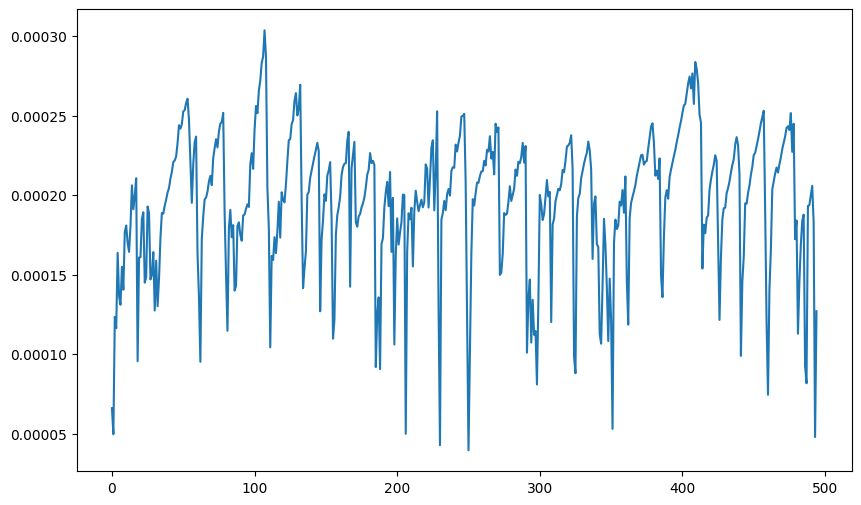

In [13]:
dataframe = pd.read_excel(f'{DATA_LOCATION}/{DATA_FILE_NAME}.xlsx', sheet_name="Sheet1", header=1, usecols=[0,1,2])
dataset = dataframe.values
#Preprocessing
# for i in range(dataset.shape[0]):
#     dataset[i][0] = int(dataset[i][0].replace("TT","").replace("'", ""))
# dataset[np.isnan(dataset)] = 0

dataset = dataset.astype('float64')
# plt.clf()
plt.figure(figsize=(10,6))
# plt.plot(dataset[:,1], color="green")
# plt.twinx()
plt.plot(dataset[:,2])
plt.rcParams.update({'font.size': 10})
plt.show()

In [14]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

In [15]:
# split into train and test sets
train_size = int(len(dataset) * TRAIN_TEST_RATIO)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

371 124


In [16]:
# pca to reduce features
# pca = PCA(n_components = 2)
# FEATURE_NUMBER = 2
# train_x = pca.fit_transform(train)
# test_x = pca.transform(test)
# # normalize x
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)
# print(train_x.shape)
# print(test_x.shape)

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, y_col=0):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, y_col])
	return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t and Y=t+1
# train_x, train_y = create_dataset(train, TIME_STEP)
# test_x, test_y = create_dataset(test, TIME_STEP)
train_x = scaler.fit_transform(train)
test_x = scaler.fit_transform(test)
train_x, _ = create_dataset(train_x, TIME_STEP)
test_x, _ = create_dataset(test_x, TIME_STEP)
_, train_y = create_dataset(train, TIME_STEP,2)
_, test_y = create_dataset(test, TIME_STEP,2)
# normalize y 
train_y = scaler.fit_transform(train_y.reshape(-1,1))
test_y = scaler.transform(test_y.reshape(-1,1))

In [19]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], TIME_STEP, FEATURE_NUMBER))
test_x = np.reshape(test_x, (test_x.shape[0], TIME_STEP, FEATURE_NUMBER))

In [20]:
# create and fit the LSTM network
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model = Sequential()
if MODEL_TYPE == "LSTM":
    model.add(LSTM(32, input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True))
    model.add(LSTM(32, input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN":
    model.add(Conv1D(32, (3), activation='relu', input_shape=(TIME_STEP,FEATURE_NUMBER)))
    # model.add(layers.MaxPooling1D((2)))
    model.add(Conv1D(64, (3), activation='relu'))
    # model.add(layers.MaxPooling1D((2)))
    model.add(Conv1D(64, (3), activation='relu'))
    model.add(MaxPooling1D((2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM":
    model.add(
        Conv1D(6, (3), activation="relu", input_shape=(TIME_STEP, 1))
    )
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN":
    model.add(
        Conv1D(64, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN2":
    model.add(
        Conv1D(128, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(
        LSTM(
            200,"relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(100,"relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN":
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN2":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(16))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN3":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1), return_sequences=True))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN4":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN5":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(1))
model.summary()
MODEL_JSON = model.to_json()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE, verbose=2, callbacks=[EARLY_STOPPING, tensorboard_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 300)               364800    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 365,101
Trainable params: 365,101
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1000
92/92 - 4s - loss: 0.0482 - 4s/epoch - 48ms/step
Epoch 2/1000
92/92 - 2s - loss: 0.0201 - 2s/epoch - 17ms/step
Epoch 3/1000
92/92 - 2s - loss: 0.0197 - 2s/epoch - 17ms/step
Epoch 4/1000
92/92 - 2s - loss: 0.0178 - 2s/epoch - 17ms/step
Epoch 5/1000
92/92 - 2s - loss: 0.0186 - 2s/epoch - 17ms/step
Epoch 6/1000
92/92 - 2s - loss: 0.0165 - 2s/epoch - 16ms/step
Epoch 7/1000
92/92 - 2s - loss: 0.0162 - 2s/epoch - 17ms/step
Epoch 8/1000
92/92 - 2s - loss: 0.0170 - 2s/epoch - 17ms/step
Epoch 9/1000
92/92 - 2s - loss: 0.0149 - 2s/epoch - 17ms/step
Epoch 10/1000
92/92 - 1s - loss: 0.0147 - 1s/epoch - 16ms/step
Epoch 11/1000
92/92 - 1s - loss: 0.0145 - 1s/epoch - 16ms/step
Epoch 12/1000
92/92 - 1s - loss: 0.0141 - 1s/epoch - 16ms/step
Epoch 13/1000
92/92 - 2s - loss: 0.0147 - 2s/epoch - 17ms/step
Epoch 14/1000
92/92 - 1s - loss: 0.0143 - 1s/epoch - 16ms/step
Epoch 15/1000
92/92 - 1s - loss: 0.0135 - 1s/epoch - 15ms/step
Epoch 16/1000
92/92 - 1s - loss: 0.0138 - 1s/epoch - 16ms/step
E

In [21]:
# save model
version = 0
if not os.path.exists(SAVE_MODEL_LOCATION):
    os.makedirs(SAVE_MODEL_LOCATION)
for dir in os.scandir(f"{SAVE_MODEL_LOCATION}/"):
    if dir.is_dir():
        version = int(dir.name) if int(dir.name) > version else version
version += 1
model.save(f"{SAVE_MODEL_LOCATION}/{version}")

INFO:tensorflow:Assets written to: ../Model/Data_for_ML_TT-DB1/15\assets


In [22]:
# predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_true = scaler.inverse_transform(train_y).reshape(1,-1)
test_predict = scaler.inverse_transform(test_predict)
test_true = scaler.inverse_transform(test_y).reshape(1,-1)
# train_predict = train_predict
# train_true = np.reshape(train_y,(1,-1))
# test_predict = test_predict
# test_true = np.reshape(test_y,(1,-1))

# calculate mean absolute error (MAE)
train_mae = mean_absolute_error(train_true[0], train_predict[:, 0])
test_mae = mean_absolute_error(test_true[0], test_predict[:, 0])
# calculate mean absolute percentage error (MAPE)
train_mape = mean_absolute_percentage_error(train_true[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(test_true[0], test_predict[:, 0])
# calculate root mean squared error (RMSE)
train_rmse = np.sqrt(mean_squared_error(train_true[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(test_true[0], test_predict[:, 0]))
# calculate root mean squared percentage error (RMSPE)
train_rmspe = np.sqrt(
    np.mean(
        np.square(((train_true[0] - train_predict[:, 0]) / train_true[0])),
        axis=0,
    )
)
test_rmspe = np.sqrt(
    np.mean(
        np.square(((test_true[0] - test_predict[:, 0]) / test_true[0])),
        axis=0,
    )
)

train_mae_output = "Train MAE Score: %.10f MAE" % train_mae
test_mae_output = "Test MAE Score: %.10f MAE" % test_mae
train_mape_output = "Train MAPE Score: %.4f MAPE" % train_mape
test_mape_output = "Test MAPE Score: %.4f MAPE" % test_mape
train_rmse_output = "Train RMSE Score: %.10f RMSE" % train_rmse
test_rmse_output = "Test RMSE Score: %.10f RMSE" % test_rmse
train_rmspe_output = (
    "Train RMSPE: %.4f RMSPE" % train_rmspe
)
test_rmspe_output = "Test RMSPE: %.4f RMSPE" % test_rmspe
print(train_mae_output)
print(test_mae_output)
print(train_mape_output)
print(test_mape_output)
print(train_rmse_output)
print(test_rmse_output)
print(train_rmspe_output)
print(test_rmspe_output)
rmse_file = open(
    f"./{SAVE_MODEL_LOCATION}/{version}/info.md", "w"
)
rmse_file.write(
    train_mae_output
    + "\n"
    + test_mae_output
    + "\n"
    + train_mape_output
    + "\n"
    + test_mape_output
    + "\n"
    + train_rmse_output
    + "\n"
    + test_rmse_output
    + "\n"
    + train_rmspe_output
    + "\n"
    + test_rmspe_output
    + "\n"
    + to_string()
)
rmse_file.close()

4/4 [==============================] - 0s 7ms/step
Train MAE Score: 0.0000212991 MAE
Test MAE Score: 0.0000196949 MAE
Train MAPE Score: 0.1504 MAPE
Test MAPE Score: 0.1349 MAPE
Train RMSE Score: 0.0000300550 RMSE
Test RMSE Score: 0.0000282472 RMSE
Train RMSPE: 0.3397 RMSPE
Test RMSPE: 0.3176 RMSPE


(495, 1)
(495, 1)


<Figure size 640x480 with 0 Axes>

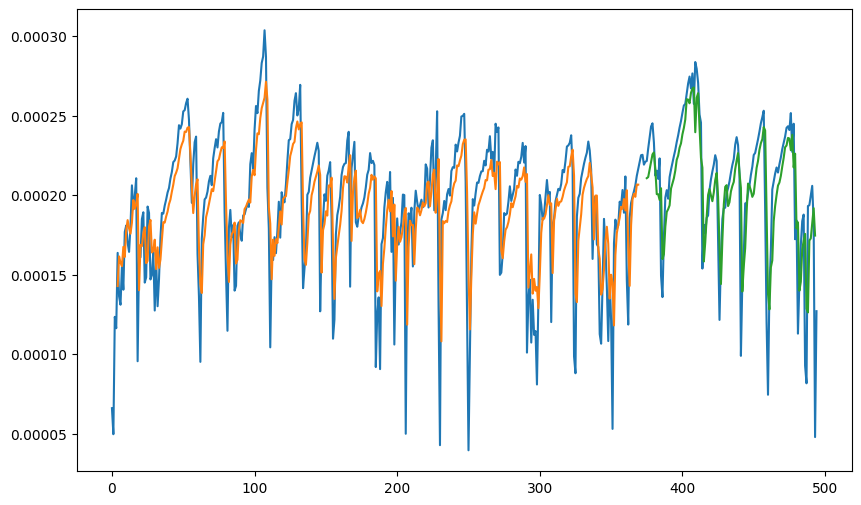

In [23]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,2]).reshape(-1,1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[TIME_STEP:len(train_predict)+TIME_STEP, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,2]).reshape(-1,1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(TIME_STEP*2)+1:len(dataset)-1, :] = test_predict

true_values = (dataset)[:,2].reshape(-1,1)
print(true_values.shape)
print(trainPredictPlot.shape)
# plot baseline and predictions
plt.clf()
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 10})
plt.plot(true_values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig(f"{SAVE_MODEL_LOCATION}/{version}/predict.png")
plt.show()